## Example notebook for downloading NEXRAD data

In [1]:
import pyart
import nexradaws

from datetime import datetime


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Download NEXRAD data for Chicago

In [2]:
# Set up the connection to the NEXRAD AWS
conn = nexradaws.NexradAwsInterface()

In [3]:
# Specify a start and end time
start_date = datetime.datetime(2020, 6, 1, 0, 0)
end_date = datetime.datetime(2019, 6, 28, 0, 0)

# Radar ID - KLOT is Chicago area
radar_id = 'KLOT'

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

In [ ]:
scans = conn.get_avail_scans_in_range(start_date, end_date, radar_id)
print("There are {} scans available between {} and {}\n".format(len(scans), start_date, end_date))
print(scans[0:4])

In [26]:
results = conn.download(scans, '../data/TestRadarData/')

0 out of 0 files downloaded...0 errors


In [6]:
scans = [x for x in results.iter_success()]

## Visualize a scan - test masking for one scan

In [4]:
radar_object = scans[50].open_pyart()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
display = pyart.graph.RadarDisplay(radar_object)
display.plot_ppi('reflectivity', sweep=0, vmin=0, vmax=60)
ax.set_xlim([-250, 250])
ax.set_ylim([-250, 250])

NameError: name 'scans' is not defined

## Masking code for a single scan

## Current criteria for a storm
reflectivity > 40 dBZ - this shows the strength of the beam scattered back to the radar. It's proportional to the sixth power of raindrop diameter. With larger drops, we get heavier rainfall, so this will be correlated with rainfall intensity.

cross correlation ratio > 0.98. The radar beam has two polarizations parallel and perpendicular to the beam. The raindrops will interact with the two polarizations differently. What this quantitity tells us is how correlated the parallel and perpendicular polarizations of reflectivity are correlated for each scatterer in the radar volume. This gives us an idea of how similar the shapes are of each scatterer in the volume. Values close to 1 tend to represent raindrops. However, clutter and debris tend to have more random shapes, so this value will be much lower than 1 in echoes that are not rain or hail.

(-250.0, 250.0, -250.0, 250.0)

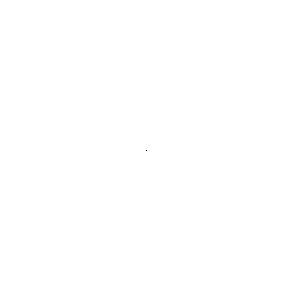

In [8]:
mask = np.where(np.logical_and(radar_object.fields['reflectivity']['data'] > 40, 
                               radar_object.fields['cross_correlation_ratio']['data'] > 0.99), 1, np.nan)
radar_object.add_field_like('reflectivity', 'storm_mask', mask, replace_existing=True)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
display = pyart.graph.RadarDisplay(radar_object)
display.plot_ppi('storm_mask', sweep=0, vmin=0, vmax=1, title='', colorbar_flag=False, cmap='Greys')
ax.set_xlim([-250, 250])
ax.set_ylim([-250, 250])
ax.set_xlabel('')
ax.set_ylabel('')
ax.axis('off')

## Loop to create PNG files of storm regions from NEXRAD data

In [ ]:
png_out_dir = '../data/4.2020/pngs/'
for my_scan in scans:
    try:
        radar_object = my_scan.open_pyart()
    except OSError:
        # Some files are corrupt, skip them
        continue
    # Parse the scan time
    rad_time = datetime.datetime.strptime(radar_object.time['units'], 'seconds since %Y-%m-%dT%H:%M:%SZ')
    
    # Apply mask here
    mask = np.logical_and(radar_object.fields['reflectivity']['data'] > 40, 
                          radar_object.fields['cross_correlation_ratio']['data'] > 0.98)
    radar_object.add_field_like('reflectivity', 'storm_mask', mask, replace_existing=True)
    
    # Create the image for DNN
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    display = pyart.graph.RadarDisplay(radar_object)
    display.plot_ppi('storm_mask', sweep=0, vmin=0, vmax=1, title='', colorbar_flag=False, cmap='Greys')
    ax.set_xlim([-250, 250])
    ax.set_ylim([-250, 250])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.axis('off')
    fig.savefig('%s%s' % (png_out_dir, rad_time.strftime('%Y%m%d-%H%M%S.png')), dpi=300)
    
    # Free memory
    plt.close(fig)
    del radar_object
    del ax
    del display

In [ ]:
radar_object.info()